In [1]:
# 1. Install the official SAM package
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1bhcyk0k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1bhcyk0k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=9995475e3564689ee4ffd5cab9e521c966ebc5d300192d46f23840c63eed4608
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzgouaoj/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [3]:
#Install dependencies- installed the official Segment Anything repository from Facebook Research along with required dependencies.
!pip install torch torchvision
!pip install opencv-python matplotlib

### Download SAM checkpoint (ViT-B)
Downloaded the pretrained ViT-B checkpoint provided by Meta, which is sufficient for base inference and fits our compute constraints.

In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-12-22 17:18:58--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.182.39, 13.249.182.62, 13.249.182.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.182.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  12.1MB/s    in 7.1s    

2025-12-22 17:19:06 (50.4 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



### Import libraries & load model

Here we load the SAM ViT-B backbone using the official registry and move it to GPU.

In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)


### Load dataset image
We load a sample image from our dataset and verify that it is correctly loaded.


(np.float64(-0.5), np.float64(2645.5), np.float64(1763.5), np.float64(-0.5))

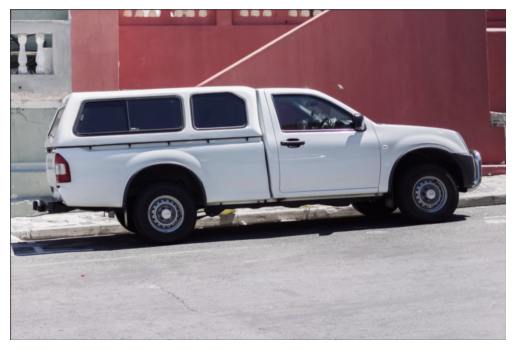

In [6]:
import requests
from PIL import Image

image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw).convert("RGB"))

plt.imshow(image)
plt.axis("off")


### Set image in SAM
The image is encoded once by the SAM image encoder before applying prompts.

In [10]:
predictor.set_image(image)

### Prompt-based segmentation (Point prompt)
We provide a point prompt and SAM generates multiple candidate masks along with confidence scores.

In [12]:
input_point = np.array([[450, 600]])
input_label = np.array([1])  # foreground point

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


### Visualize generated masks
This visualization shows the masks generated by SAM overlaid on the original image.

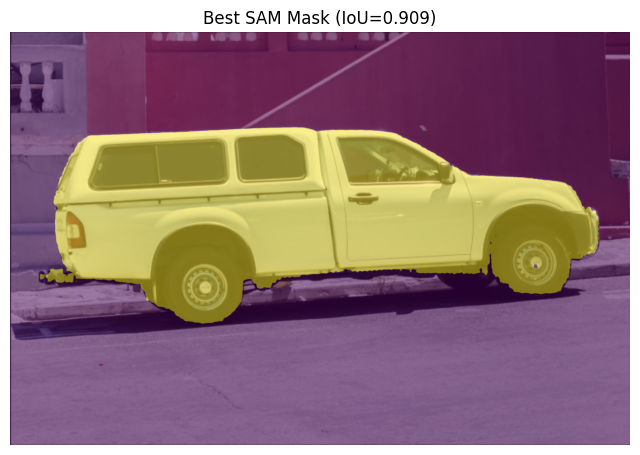

In [17]:
input_point = np.array([
    [450, 600],  # window
    [650, 700],  # car body
    [850, 720],  # wheel area
])
input_label = np.array([1, 1, 1])

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


best_mask_idx = scores.argmax()
best_mask = masks[best_mask_idx]

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(best_mask, alpha=0.5)
plt.axis("off")
plt.title(f"Best SAM Mask (IoU={scores[best_mask_idx]:.3f})")
plt.show()
